##### Credit card fraud classification | Classification on imbalanced dataset

The aim of this project is to explore effectiveness of supervised machine learning algorithms in identifying fraud transactions using the anonimised credit card transactional data.

There are various issues when working with highly imbalanced datasets and in this notebook they will be addressed by using class weights in model parameters and creating a less imbalanced dataset. The results will be compared against default setting models and a standard dataset.


Dataset is from Kaggle - https://www.kaggle.com/mlg-ulb/creditcardfraud

Plan is following:
- Load and inspect the Data
- Clean if needed
- Visualise
- Prepare for modeling
- Run several models using CrossValidation
- Pick one model based on initial results and tune hyper-parameters
- Run refined model on the test set
- Evaluate performance
- Check feature importance
- Write conclusions


In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import average_precision_score, confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from inspect import signature

import pandas_profiling as pp
import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns; sns.set()
%matplotlib inline


# Load and inspect the Data

In [2]:
df = pd.read_csv("creditcard.csv")

In [3]:
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [4]:
df.sample(10)

Time        V1        V2        V3        V4        V5        V6  \
197764  132165.0  0.374356 -0.281083  0.454030 -1.659113 -0.335695 -0.059848   
90417    63012.0 -0.968456  1.401664  1.075821 -0.039416 -0.528924 -0.993931   
120638   75904.0  1.300726  0.136875  0.036381  0.234988  0.104700 -0.012016   
122449   76564.0 -1.427123 -1.725958  1.630121 -3.402113 -0.962462 -1.125084   
17491    28769.0  1.190398  0.279456  0.266907  1.141126 -0.294990 -0.957127   
191544  129308.0  0.054682  1.856500 -4.075451  4.100098 -0.800931 -0.292502   
253201  156141.0  2.047576  0.578490 -2.368910  0.782196  0.509553 -1.821634   
180863  124726.0 -1.110844  1.723244  0.495303  1.006120  0.420924 -1.002712   
283885  171956.0 -0.231241  0.946482 -0.210952 -0.468765  0.877642 -0.556663   
201931  134098.0  1.998748 -0.454235 -2.246681 -0.917923  2.161642  3.328364   

              V7        V8        V9  ...       V21       V22       V23  \
197764 -0.035116 -0.025608 -0.586174  ...  0.032594  0.000736  0.213085   
90417   0.256144  0.436638 -0.202057  ... -0.229583 -0.720430  0.053119   
120638 -0.098973  0.043188 -0.063256  ... -0.288342 -0.884941 -0.013803   
122449  0.950451 -0.430310  0.435976  ... -0.119408 -0.184113  0.415384   
17491   0.258182 -0.242884 -0.026719  ...  0.044902  0.115355 -0.123956   
191544 -2.317431  1.189747 -0.786238  ...  0.618248  0.800932  0.130016   
253201  0.365921 -0.403327  0.531257  ...  0.096247  0.473928 -0.044558   
180863  1.119133  0.125647 -1.056206  ...  0.089830  0.361380 -0.473475   
283885  0.962596 -0.424429 -0.043668  ... -0.149235 -0.390965  0.170329   
201931 -0.643572  0.846360  0.380684  ... -0.449453 -1.470259  0.576124   

             V24       V25       V26       V27       V28  Amount  Class  
197764 -1.034148 -0.972851 -0.479395  0.140991  0.113270   61.29      0  
90417   0.325139 -0.156828  0.082301  0.238426  0.116192    1.98      0  
120638 -0.855570  0.327376  0.151141 -0.037333 -0.004140    0.99      0  
122449  0.368242  0.777940 -0.853614 -0.159316 -0.114872  299.96      0  
17491   0.400475  0.678634 -0.331550  0.008728  0.025315   32.27      0  
191544  0.288946 -0.366658  0.030307  0.431182  0.110698   80.90      1  
253201 -0.172425  0.251499 -0.102661  0.019108  0.007596    1.00      0  
180863  0.417377  1.132964 -0.202024  0.033692  0.045286    4.70      0  
283885 -0.678644 -0.836710  0.137343 -0.452459  0.116214    1.98      0  
201931  0.651245 -0.691785  0.039401 -0.051973 -0.051316   23.04      0  

[10 rows x 31 columns]

In [27]:
# pp.ProfileReport(df) # Skipping. Produces a long report that is badly displayed on GitLab

# Data Cleaning

- There are 1081 duplicates in this dataset.

## Address the duplicates

In [6]:
dupl_df = df[df.duplicated()]

dupl_df.Class.value_counts()

0    1062
1      19
Name: Class, dtype: int64

Out of 492 identified fraud cases, 19 of them are among duplicates. Removing all duplicates.

In [7]:
df.shape

(284807, 31)

In [8]:
df = df.drop_duplicates()
df.shape

(283726, 31)

# Visualising and comparing similarities/differences between 2 classes

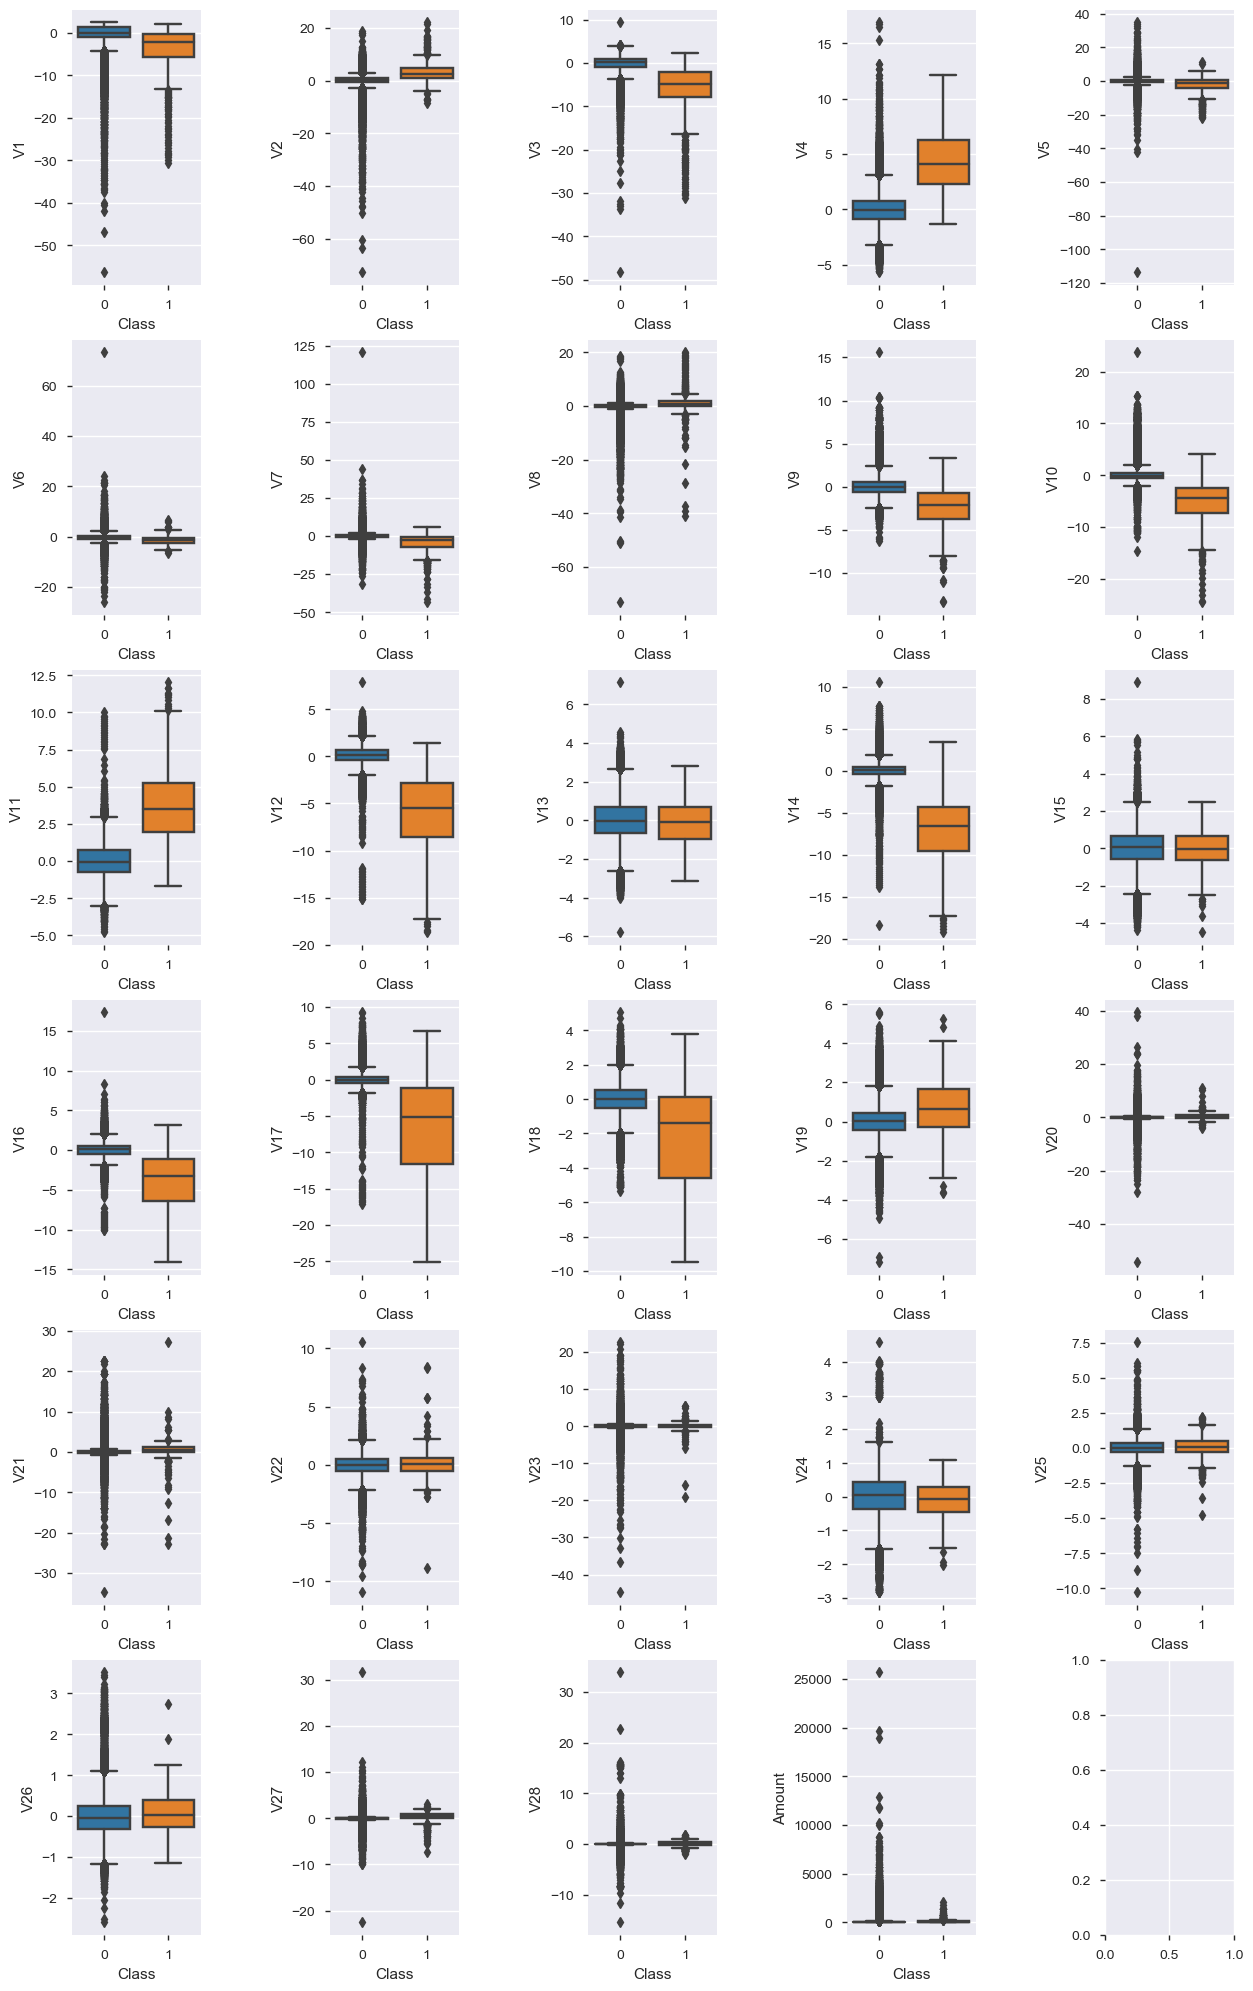

In [9]:
fig, axes = plt.subplots(6,5, figsize=(15,25), gridspec_kw={'wspace': 1})

for pos, col in enumerate(list(df.columns.values)[1:-1]):
    sns.boxplot(y=col, x="Class", data=df, ax=axes.flatten()[pos])

It is clear, that some of the features have a clear differences between IQR for Fraud and non-Fraud groups. <br> 
The differences in those features should be important in classification so it will be interesting to compare results between at least 2 datasets - one with all features and one with selected features.

# Modeling

This dataset has a typical class imbalance when we have to deal with rare event detection.<br>
To deal with this, different approches will be used by comparing algorithms with different parameters on different datasets. <br> <br>
Creating 3 datasets in total and performing CrossValidation on several classification models.
 - Full dataset, with all features
 - With selected features, the ones that shows biggest differences between classes
 - Downsampled majority class so the imbalance becomes around 10:1.

In [10]:
# Creating 3 datasets

X = df.loc[:, df.columns[1:-1]]
y = df.Class

# All features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Selected features
selected = ['V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X[selected], y, test_size=0.2, random_state=42)

# Downsampled majority class
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=0.1, random_state=42) # Sampling strategy is set to have a ~10:1 balance

X_res, y_res = rus.fit_resample(X, y)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


Using TensorFlow backend.
C:\Users\Andrius\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Andrius\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Andrius\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Andrius\Anaconda3\lib\site-packages\tensorflow\python\framework\d

In [11]:
y_train.value_counts(), y_train2.value_counts(), y_train3.value_counts()

(0    226597
 1       383
 Name: Class, dtype: int64, 0    226597
 1       383
 Name: Class, dtype: int64, 0    3794
 1     368
 Name: Class, dtype: int64)

In [12]:
class_count1 = y_train.value_counts()
class_count2 = y_train3.value_counts()

imbalance1 = class_count1[0]/class_count1[1] #To use for XGBOOST imbalance parameter on first 2 datasets
imbalance2 = class_count2[0]/class_count2[1] # To use for the 3rd dataset

imbalance1, imbalance2

(591.6370757180157, 10.309782608695652)

In [13]:
datasets = {
    "Full" : [X_train, X_test, y_train, y_test], 
    "Selected Features" : [X_train2, X_test2, y_train2, y_test2],
    "Downsampled majority" : [X_train3, X_test3, y_train3, y_test3]
}

In [14]:
# Model list to test

models = {
    "LogisticRegression" : LogisticRegression(solver="newton-cg"),
    "LogisticRegression balanced classes" : LogisticRegression(solver="newton-cg", class_weight='balanced'),
    "RandomForestClassifier" : RandomForestClassifier(n_jobs=-1),
    "RandomForestClassifier balanced classes" : RandomForestClassifier(n_jobs=-1, class_weight='balanced'),
    "XGB Classifier" : XGBClassifier(n_jobs=-1),
    "XGB Classifier balanced classes" : XGBClassifier(n_jobs=-1, scale_pos_weight=imbalance1)
}

## Setting the baseline score

In [15]:
def baseline_scores():
    for (dataset_name, dataset) in datasets.items():

        for (clf_name, model_name) in models.items():

            if dataset_name != "Downsampled majority" or clf_name != "XGB Classifier balanced classes":
                X_train, X_test, y_train, y_test = dataset

                scores = cross_validate(model_name,
                                        X_train,
                                        y_train,
                                        scoring=('recall', "precision", "f1"),
                                        cv=3,
                                        n_jobs=-1)

                print("{}, {} dataset".format(clf_name, dataset_name))
                print('Recall mean is {}'.format(
                    str(np.mean(scores['test_recall']))))
                print('Precision mean is {}'.format(
                    str(np.mean(scores['test_precision']))))
                print('F1 mean is {}'.format(str(np.mean(scores['test_f1']))))
                print('\n')

            else: # Additional condition to run different configuration for Downsampled dataset
                X_train, X_test, y_train, y_test = dataset
                model_name = XGBClassifier(n_jobs=-1, scale_pos_weight=imbalance2)
                clf_name = "XGB Classifier balanced classes 2"

                scores = cross_validate(model_name,
                                        X_train,
                                        y_train,
                                        scoring=('recall', "precision", "f1"),
                                        cv=3,
                                        n_jobs=-1)

                print("{}, {} dataset".format(clf_name, dataset_name))
                print('Recall mean is {}'.format(
                    str(np.mean(scores['test_recall']))))
                print('Precision mean is {}'.format(
                    str(np.mean(scores['test_precision']))))
                print('F1 mean is {}'.format(str(np.mean(scores['test_f1']))))
                print('\n')

In [16]:
baseline_scores()

LogisticRegression, Full dataset
Recall mean is 0.6081651902887139
Precision mean is 0.8556711302407142
F1 mean is 0.7096326858721977


LogisticRegression balanced classes, Full dataset
Recall mean is 0.9059424212598426
Precision mean is 0.060500167323088015
F1 mean is 0.11326858630835289


RandomForestClassifier, Full dataset
Recall mean is 0.7779896653543307
Precision mean is 0.934627163759389
F1 mean is 0.8486492555567585


RandomForestClassifier balanced classes, Full dataset
Recall mean is 0.7492823162729659
Precision mean is 0.9501953763972749
F1 mean is 0.8377306200299725


XGB Classifier, Full dataset
Recall mean is 0.775385498687664
Precision mean is 0.919344582240881
F1 mean is 0.8407320121708516


XGB Classifier balanced classes, Full dataset
Recall mean is 0.8641117125984251
Precision mean is 0.30240688880609073
F1 mean is 0.4452050107240972


LogisticRegression, Selected Features dataset
Recall mean is 0.5873113517060368
Precision mean is 0.8455705009276437
F1 mean is 0.69

Several conclusions from the results above:

- Typical imbalanced dataset problem - balancing between low False Positives and high False Negatives. If the focus is on capturing as many fraud cases as possible, then the higher Recall the better. The only question is - at what price, i.e. how many false alarm there will be in the process. <br>

- Using Selected Features dataset returns near identical results to the full, but works much faster, so it will be used as a benchmark dataset for the next steps.

- Using downsampled dataset helps to increase fraud detection even more while false alarms stay lower than with other datasets. Question is - how the model would perform on a regular data? <br>

- To test, if training on downsampled data helps to make model better, two versions of XGBOOST will be trained 1)using Selected Features dataset, 2)using downsampled dataset and their performance will be evaluated on a test dataset. 


## Parameter tuning for XGBOOST

Optimizing XGBOOST model for recall, to reduce undetected fraud transactions.

### Full dataset

In [17]:
cv_parameters = {'max_depth': [3,5],
                 'n_estimators': [80, 100, 130, 160, 200],
                 'scale_pos_weight': [1, imbalance1, 2*imbalance1]}
fix_parameters = {'learning_rate': 0.3,
                  'objective': 'binary:logistic'}

csv = GridSearchCV(XGBClassifier(**fix_parameters),
                   cv_parameters, scoring='recall', cv=3, n_jobs=-1)

csv.fit(X_train2.values, y_train2.values)

csv.best_params_

{'max_depth': 3, 'n_estimators': 80, 'scale_pos_weight': 1183.2741514360314}

### Run the model with the best parameters on Test set

In [18]:
def run_model(name, X_train, y_train, X_test, y_test):
    clf = name
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    confusion = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3,3))
    sns.heatmap(confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56656
           1       0.05      0.90      0.09        90

    accuracy                           0.97     56746
   macro avg       0.52      0.94      0.54     56746
weighted avg       1.00      0.97      0.98     56746



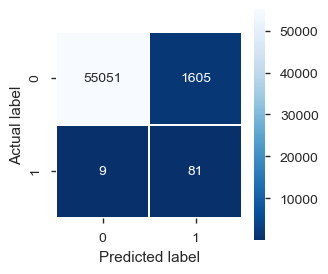

In [19]:
run_model(XGBClassifier(n_jobs=-1, **csv.best_params_), X_train2, y_train2, X_test2, y_test2)

### Downsampled dataset

In [20]:
cv_parameters = {'max_depth': [3,5],
                 'n_estimators': [80, 100, 130, 160, 200],
                 'scale_pos_weight': [1, imbalance2, 2*imbalance2]}
fix_parameters = {'learning_rate': 0.3,
                  'objective': 'binary:logistic'}

csv = GridSearchCV(XGBClassifier(**fix_parameters),
                   cv_parameters, scoring='recall', cv=3, n_jobs=-1)

csv.fit(X_train3.values, y_train3.values)

csv.best_params_

{'max_depth': 3, 'n_estimators': 130, 'scale_pos_weight': 20.619565217391305}

### Run the model with the best parameters on Test set

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56656
           1       0.12      0.99      0.22        90

    accuracy                           0.99     56746
   macro avg       0.56      0.99      0.61     56746
weighted avg       1.00      0.99      0.99     56746



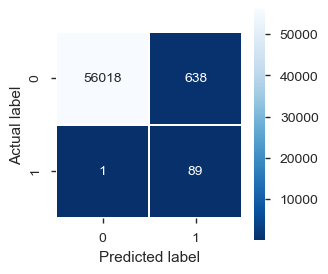

In [21]:
run_model(XGBClassifier(n_jobs=-1, **csv.best_params_), X_train3, y_train3, X_test, y_test)

## Run the model and get probability output for PR-AUC curve

In [22]:
model = XGBClassifier(n_jobs=-1, **csv.best_params_)
model.fit(X_train3, y_train3)

# Selecting second column for the 1st class predictions
probabilities = model.predict_proba(X_test)[:, 1]

In [23]:
average_precision = average_precision_score(y_test, probabilities)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.84


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.84')

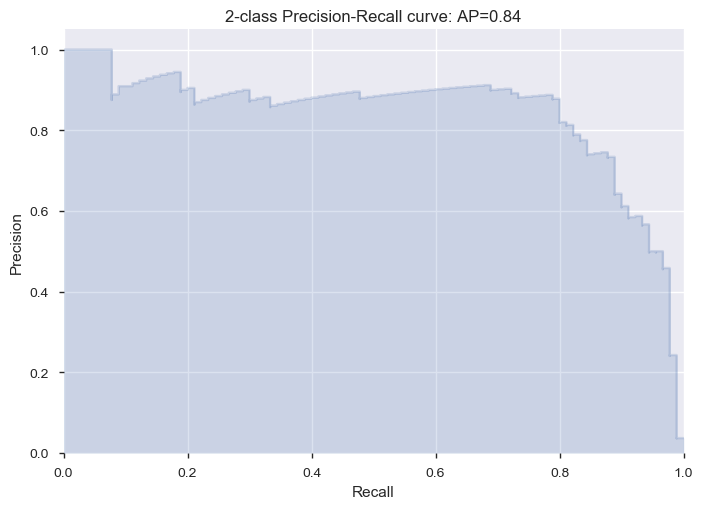

In [24]:
# Plotting the curve

precision, recall, _ = precision_recall_curve(y_test, probabilities)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

##### This Precision-Recall curve shows what was seen in the results from the other algorithms too - there is a good precision and recall balance up to ~0.8 on recall measurement. If we want to catch more Fraud transactions, then the false alarms start to increase.

# Which features are the most important in fraud/no fraud decision?

In [25]:
model.feature_importances_

array([0.00998861, 0.01213166, 0.01092692, 0.05666399, 0.01127617,
       0.01268667, 0.0253562 , 0.0499621 , 0.00667212, 0.10139395,
       0.01819021, 0.03282401, 0.01520105, 0.35227343, 0.01070566,
       0.01362156, 0.01938566, 0.01164993, 0.02519979, 0.05113841,
       0.02189174, 0.01424814, 0.01388685, 0.0089176 , 0.01238557,
       0.01435992, 0.01568214, 0.01684957, 0.03453028], dtype=float32)

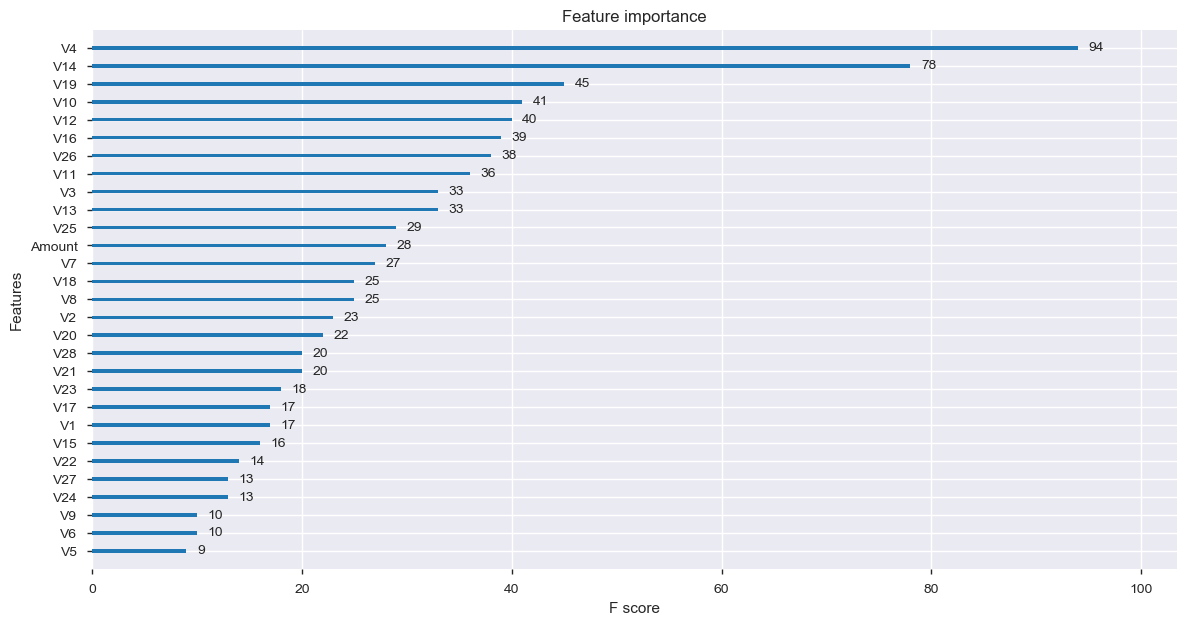

In [26]:
plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(model)

None

Top 5 most prominent features are V4, V14, V19, V12 V10 and as expected, the differences between two groups are visible in visual boxplot comparison. In Fraud group most of the values, compared to the regular transactions, are outside of the non-Fraud IQR ranges. 

# Conclusions:

- Even though it is possible to have a good results for such imbalanced dataset without using sampling techniques, making a more balanced dataset by reducing non-fraud cases helps to better identify fraud cases without a significant increase in false alarms;
- Depending on the objectives, the ratio between missed fraud cases/false alarms could be adjusted using different parameters. Optimising for F1 score would leave several more undetected cases, but would significantly decrease false alarms.

The results as well confirms the importance of data quality that is being fed to the algorithms - reducing the amount of data and making a more balanced dataset significantly increases classification quality and training time.
